In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.manifold import TSNE


In [20]:
# Load data from CSV files
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')



In [21]:
# Merge the customers and transactions data on 'CustomerID'
merged_data = pd.merge(transactions, customers, on='CustomerID', how='inner')

# Calculate total spent and transaction count for each customer
customer_summary = merged_data.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    transaction_count=pd.NamedAgg(column='TransactionID', aggfunc='nunique')
).reset_index()

# Merge back with customer data to get profile info
customer_summary = pd.merge(customer_summary, customers[['CustomerID', 'Region']], on='CustomerID', how='left')


In [22]:
# Encode 'Region' as categorical variable (using one-hot encoding)
customer_summary = pd.get_dummies(customer_summary, columns=['Region'], drop_first=True)

# Select features for clustering
features = customer_summary[['total_spent', 'transaction_count'] + [col for col in customer_summary.columns if 'Region' in col]]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [23]:
# ---- Elbow Method (For Optimal Cluster Selection) ----
inertia = []
sil_scores = []

for n_clusters in range(2, 11):  # Try for cluster values from 2 to 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(scaled_features, kmeans.labels_))  # Calculate silhouette score


C:\Users\Nikita Srivastava\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nikita Srivastava\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nikita Srivastava\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Nikita Srivastava\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

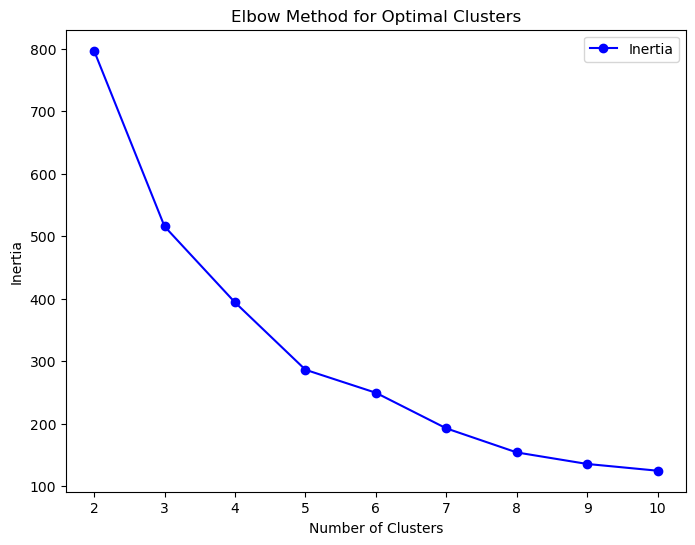

In [24]:
# Plot the Elbow Curve (Inertia vs Number of Clusters)
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='-', color='b', label='Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()
plt.show()



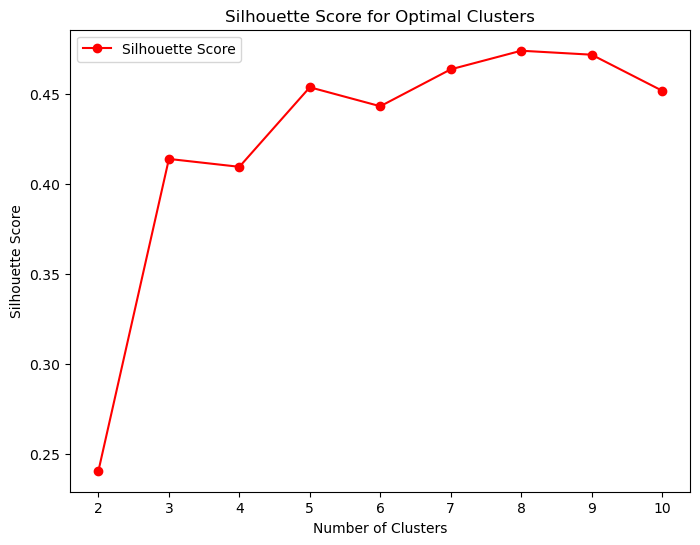

In [25]:
# Plot the Silhouette Scores for each number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), sil_scores, marker='o', linestyle='-', color='r', label='Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

In [26]:
# ---- Choose Optimal Number of Clusters ----
optimal_clusters = 5  # Based on your evaluation from Elbow and Silhouette plots (adjust this based on the plots)
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(scaled_features)


C:\Users\Nikita Srivastava\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [27]:
# Add the cluster labels to the dataset
customer_summary['cluster'] = kmeans.labels_

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, kmeans.labels_)
print(f'Davies-Bouldin Index: {db_index}')

# Calculate Silhouette Score
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')


Davies-Bouldin Index: 0.8592678851996711
Silhouette Score: 0.45353202457855835


In [28]:
# Reduce the dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

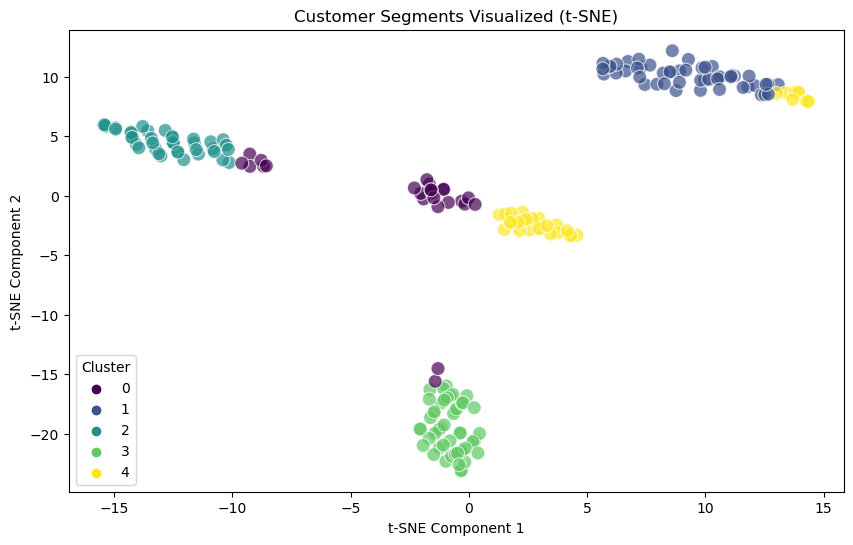

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'scaled_features' is the scaled version of your data and 'kmeans' is the fitted KMeans model

# Apply t-SNE to reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(scaled_features)  # Fit t-SNE to the scaled features

# Plot the clusters using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_components[:, 0], y=tsne_components[:, 1], hue=customer_summary['cluster'], 
                palette='viridis', s=100, alpha=0.7, edgecolor='w')
plt.title('Customer Segments Visualized (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()



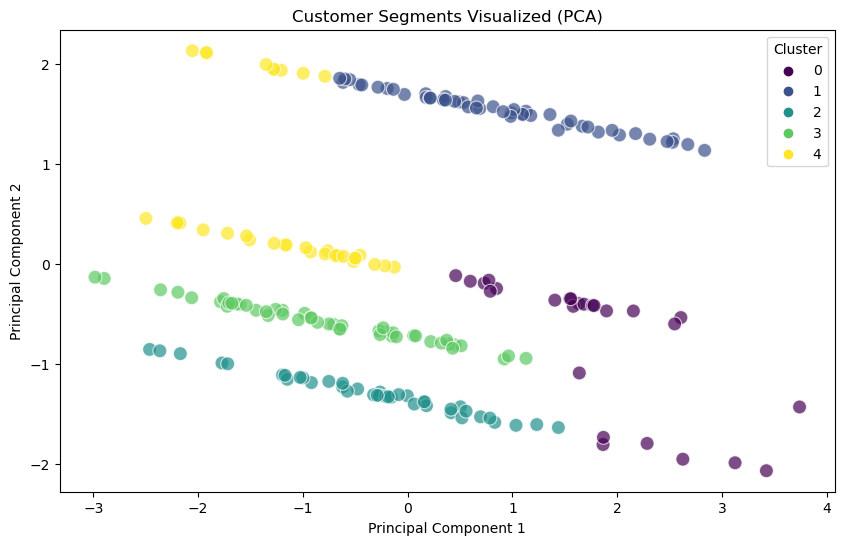

In [29]:
# Plot the clusters using PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=customer_summary['cluster'], palette='viridis', s=100, alpha=0.7, edgecolor='w')
plt.title('Customer Segments Visualized (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


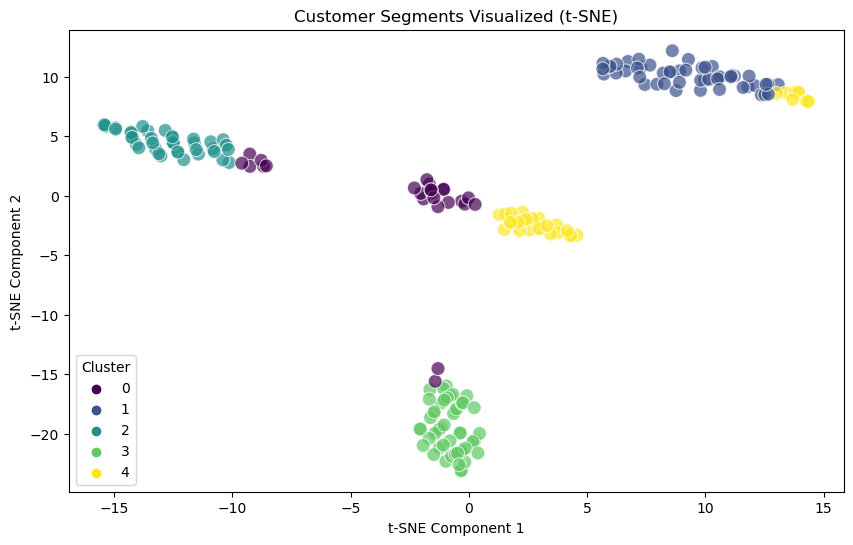

In [30]:
# ---- t-SNE Visualization ----
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_components[:, 0], y=tsne_components[:, 1], hue=customer_summary['cluster'], palette='viridis', s=100, alpha=0.7, edgecolor='w')
plt.title('Customer Segments Visualized (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

In [31]:
# Display the cluster centers (mean values of the features for each cluster)
print(f'Cluster Centers:\n{kmeans.cluster_centers_}')

# Check the number of customers in each cluster
cluster_sizes = customer_summary['cluster'].value_counts()
print(f'Cluster Sizes:\n{cluster_sizes}')

Cluster Centers:
[[ 1.28933440e+00  1.42680903e+00 -4.01934285e-01 -9.16921205e-04
  -6.49175301e-01]
 [ 4.13370651e-01  2.98646254e-01 -5.79284446e-01 -5.48318881e-01
   1.54041597e+00]
 [-3.34504684e-01 -1.71070771e-01 -5.79284446e-01  1.82375628e+00
  -6.49175301e-01]
 [-1.90311403e-01 -2.48976912e-01  1.72626765e+00 -5.48318881e-01
  -6.49175301e-01]
 [-9.05031209e-01 -9.49589279e-01 -5.79284446e-01 -5.48318881e-01
  -8.61375460e-02]]
Cluster Sizes:
1    50
3    48
2    40
4    35
0    26
Name: cluster, dtype: int64


In [32]:
# Save the final data with cluster labels to a CSV file
customer_summary.to_csv('Clustered_Customers.csv', index=False)